# Importing necessary packages

## General packages

In [1]:
import pandas as pd
from tqdm.auto import tqdm
tqdm.pandas()
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns

## Electra classifier

In [2]:
print("Preparing Electra Classifier...")
from electra_classifier import *

best_model_path = "electra_cls/lightning_logs/version_18/checkpoints/epoch=9-step=3629.ckpt"
emotion_categories = ['admiration', 'amusement', 'anger', 'annoyance', 'approval', 'caring',
       'confusion', 'curiosity', 'desire', 'disappointment', 'disapproval',
       'disgust', 'embarrassment', 'excitement', 'fear', 'gratitude', 'grief',
       'joy', 'love', 'nervousness', 'optimism', 'pride', 'realization',
       'relief', 'remorse', 'sadness', 'surprise', 'neutral']

MODEL_NAME = "google/electra-base-discriminator"
tokenizer = ElectraTokenizer.from_pretrained(MODEL_NAME)

trained_model = EmotionClassifier.load_from_checkpoint(
    # trainer.checkpoint_callback.best_model_path,
    best_model_path,
    n_classes=len(emotion_categories)
)

def predict_emotion_and_probability(text):
    encoding = tokenizer(
          text,
          max_length=64, 
          truncation=True,
          padding="max_length",
          add_special_tokens=True,
          return_token_type_ids=False,
          return_attention_mask=True,
          return_tensors="pt"
      )
    outputs = trained_model(**encoding)
    probabilities = list(torch.softmax(outputs, dim=-1).detach().numpy().flatten())
    emotion_idx = torch.argmax(outputs, dim=-1).item() 
    predicted_emotion = emotion_categories[emotion_idx]

    emotion_categories_list = list(emotion_categories)
    probabilities, emotion_categories_list = zip(*sorted(zip(probabilities, emotion_categories_list)))
    probabilities = probabilities[::-1]
    emotion_categories_list = emotion_categories_list[::-1]
    emotion_probability = round(100*probabilities[0], 2)#:.2f

    return predicted_emotion, emotion_probability

print("Electra Classifier is ready!")

Preparing Electra Classifier...


Global seed set to 42
Some weights of the model checkpoint at google/electra-base-discriminator were not used when initializing ElectraClassifier: ['discriminator_predictions.dense_prediction.weight', 'discriminator_predictions.dense.bias', 'discriminator_predictions.dense_prediction.bias', 'discriminator_predictions.dense.weight']
- This IS expected if you are initializing ElectraClassifier from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing ElectraClassifier from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of ElectraClassifier were not initialized from the model checkpoint at google/electra-base-discriminator and are newly initialized: ['classifier.dense.weight', 'classifier.out_proj.wei

Electra Classifier is ready!


In [3]:
sample_text = "I do! I was so happy when I opened the box and that fat mofo jumped out!"
predict_emotion_and_probability(sample_text)

('joy', 98.35)

# Importing data

In [4]:
chatept_output_10 = pd.read_pickle("ChatEPT/first_10_percent_grouped_by_df")
chatept_output_10 = chatept_output_10.drop('utterance_2_emotion', axis=1)
chatept_output_10.head()

,conv_id,context,utterance,utterance_minus_2_emotion,utterance_minus_2_emotion_conf,chatgpt_response_no_emotion,chatgpt_emotional_response
0,hit:0_conv:1,sentimental,[I remember going to see the fireworks with my...,neutral,99.86,I'm sorry to hear that. It's tough losing a go...,"(neutral, 99.86, I'm sorry to hear that. Losin..."
1,hit:10000_conv:20000,surprised,"[My girlfriend got me a pet toad today!, Do yo...",joy,98.35,That's great to hear! Toads can make wonderful...,"(joy, 98.35, That's great to hear! Toads can m..."
2,hit:10000_conv:20001,impressed,"[I really like the new paint job on my house.,...",neutral,91.12,That sounds like a beautiful combination of co...,"(neutral, 91.12, Blue and yellow is a lovely c..."
3,hit:10001_conv:20002,lonely,[I went to the skating rink all by myself toda...,disappointment,31.49,I'm sorry to hear that. It's tough to feel lef...,"(disappointment, 31.49, I'm sorry to hear that..."
4,hit:10002_conv:20004,ashamed,[I was walking on the road. I saw a beggar and...,embarrassment,99.49,It's never too late to help someone in need. N...,"(embarrassment, 99.49, That's completely under..."


# Analyzing results

## Labelling ChatEPT responses with electra emotions

### Non emotional version

In [5]:
chatept_output_10["no_emotion_chatgpt_response_emotion"] = chatept_output_10.chatgpt_response_no_emotion.progress_apply(lambda x: predict_emotion_and_probability(x))

  0%|          | 0/1778 [00:00<?, ?it/s]

In [6]:
chatept_output_10.head()

,conv_id,context,utterance,utterance_minus_2_emotion,utterance_minus_2_emotion_conf,chatgpt_response_no_emotion,chatgpt_emotional_response,no_emotion_chatgpt_response_emotion
0,hit:0_conv:1,sentimental,[I remember going to see the fireworks with my...,neutral,99.86,I'm sorry to hear that. It's tough losing a go...,"(neutral, 99.86, I'm sorry to hear that. Losin...","(grief, 55.02)"
1,hit:10000_conv:20000,surprised,"[My girlfriend got me a pet toad today!, Do yo...",joy,98.35,That's great to hear! Toads can make wonderful...,"(joy, 98.35, That's great to hear! Toads can m...","(admiration, 90.69)"
2,hit:10000_conv:20001,impressed,"[I really like the new paint job on my house.,...",neutral,91.12,That sounds like a beautiful combination of co...,"(neutral, 91.12, Blue and yellow is a lovely c...","(admiration, 90.89)"
3,hit:10001_conv:20002,lonely,[I went to the skating rink all by myself toda...,disappointment,31.49,I'm sorry to hear that. It's tough to feel lef...,"(disappointment, 31.49, I'm sorry to hear that...","(remorse, 82.51)"
4,hit:10002_conv:20004,ashamed,[I was walking on the road. I saw a beggar and...,embarrassment,99.49,It's never too late to help someone in need. N...,"(embarrassment, 99.49, That's completely under...","(caring, 94.53)"


### Emotional version

In [7]:
chatept_output_10["emotional_chatgpt_response_emotion"] = chatept_output_10.chatgpt_emotional_response.progress_apply(lambda x: predict_emotion_and_probability(x[2]))

  0%|          | 0/1778 [00:00<?, ?it/s]

In [8]:
chatept_output_10.head()

,conv_id,context,utterance,utterance_minus_2_emotion,utterance_minus_2_emotion_conf,chatgpt_response_no_emotion,chatgpt_emotional_response,no_emotion_chatgpt_response_emotion,emotional_chatgpt_response_emotion
0,hit:0_conv:1,sentimental,[I remember going to see the fireworks with my...,neutral,99.86,I'm sorry to hear that. It's tough losing a go...,"(neutral, 99.86, I'm sorry to hear that. Losin...","(grief, 55.02)","(sadness, 97.31)"
1,hit:10000_conv:20000,surprised,"[My girlfriend got me a pet toad today!, Do yo...",joy,98.35,That's great to hear! Toads can make wonderful...,"(joy, 98.35, That's great to hear! Toads can m...","(admiration, 90.69)","(admiration, 85.92)"
2,hit:10000_conv:20001,impressed,"[I really like the new paint job on my house.,...",neutral,91.12,That sounds like a beautiful combination of co...,"(neutral, 91.12, Blue and yellow is a lovely c...","(admiration, 90.89)","(love, 94.29)"
3,hit:10001_conv:20002,lonely,[I went to the skating rink all by myself toda...,disappointment,31.49,I'm sorry to hear that. It's tough to feel lef...,"(disappointment, 31.49, I'm sorry to hear that...","(remorse, 82.51)","(optimism, 70.82)"
4,hit:10002_conv:20004,ashamed,[I was walking on the road. I saw a beggar and...,embarrassment,99.49,It's never too late to help someone in need. N...,"(embarrassment, 99.49, That's completely under...","(caring, 94.53)","(approval, 57.74)"


In [9]:
outputs_df = chatept_output_10[["no_emotion_chatgpt_response_emotion", "emotional_chatgpt_response_emotion"]]
outputs_df = outputs_df.rename(columns={'no_emotion_chatgpt_response_emotion': 'non_emotional', 'emotional_chatgpt_response_emotion': 'emotional'})

outputs_df[['non_emotional_emotion', 'non_emotional_conf']] = outputs_df['non_emotional'].apply(lambda x: pd.Series(x))
outputs_df = outputs_df.drop('non_emotional', axis=1)

outputs_df[['emotional_emotion', 'emotional_conf']] = outputs_df['emotional'].apply(lambda x: pd.Series(x))
outputs_df = outputs_df.drop('emotional', axis=1)

outputs_df.head()

,non_emotional_emotion,non_emotional_conf,emotional_emotion,emotional_conf
0,grief,55.02,sadness,97.31
1,admiration,90.69,admiration,85.92
2,admiration,90.89,love,94.29
3,remorse,82.51,optimism,70.82
4,caring,94.53,approval,57.74


In [10]:
agreements_df = outputs_df[outputs_df.non_emotional_emotion == outputs_df.emotional_emotion]
agreements = len(agreements_df)
print(f"So {round(100*agreements/len(outputs_df))}% of the responses kept the same emotion label.\nHow about the emotion intensity?")

So 46% of the responses kept the same emotion label.
How about the emotion intensity?


In [72]:
changes_per_emotion_category = []
supports = []
for i in range(len(emotion_categories)):
    emotion_i = emotion_categories[i]
    df_of_emotion_i = agreements_df[agreements_df.non_emotional_emotion == emotion_i]
    mean_non_emotional = df_of_emotion_i.non_emotional_conf.mean()
    mean_emotional = df_of_emotion_i.emotional_conf.mean()
    change = mean_non_emotional - mean_emotional
    changes_per_emotion_category.append(change)
    support = len(df_of_emotion_i)
    supports.append(support)
    #print(f"{emotion_i.upper()} was changed by {np.floor(change)}% with a support of {len(df_of_emotion_i)}.")
sum_mean = np.nansum(np.array(changes_per_emotion_category))
avg_mean = np.nanmean(np.array(changes_per_emotion_category))
#changes_df = pd.Dataframe({"Emotion": emotion_categories, "ChatGPT_intensity})
print(f"On average, the prompts increased emotional intensity by {int(avg_mean)}% or sum: {int(sum_mean)}%.")

On average, the prompts increased emotional intensity by 4% or sum: 87%.


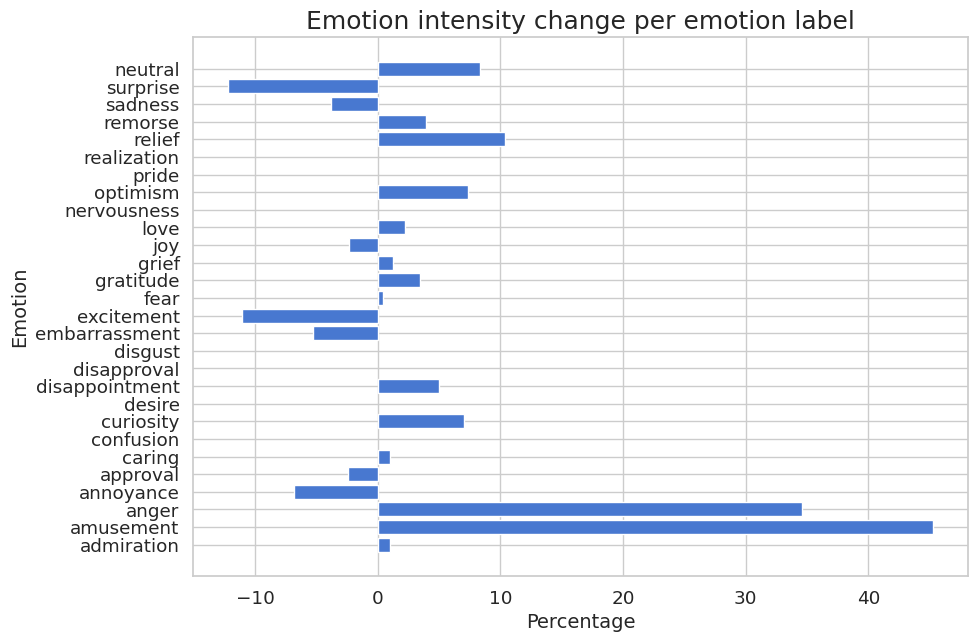

In [12]:
# Create a horizontal bar chart
fig, ax = plt.subplots(figsize=(10,7))
ax.barh(emotion_categories, changes_per_emotion_category, color='b')

# Set chart title and axis labels
ax.set_title('Emotion intensity change per emotion label', fontsize=18)
ax.set_xlabel('Percentage', fontsize=14)
ax.set_ylabel('Emotion', fontsize=14)

# Show the chart
plt.show()

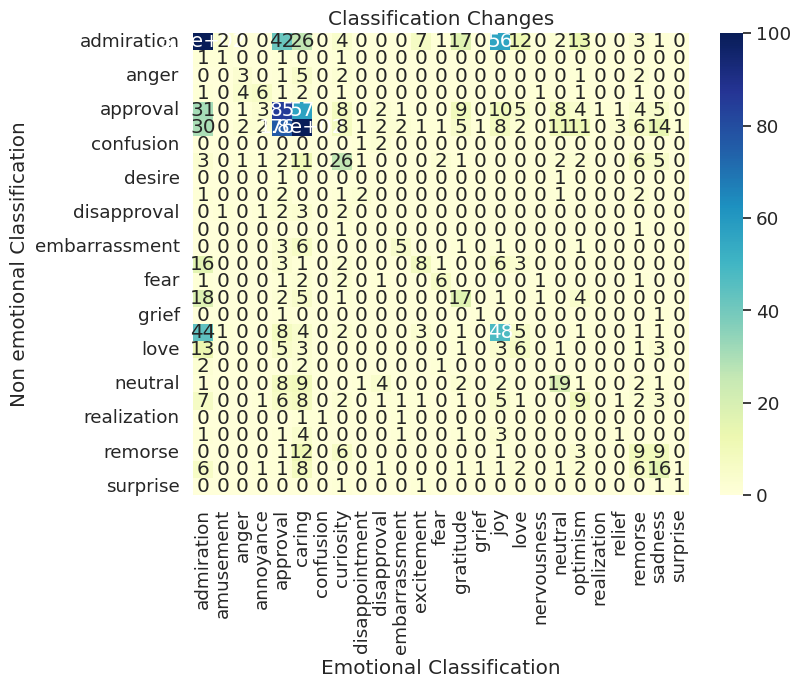

In [13]:
# Create two sample Series
s1 = outputs_df.non_emotional_emotion
s2 = outputs_df.emotional_emotion

# Create a crosstab of the two Series
crosstab = pd.crosstab(s1, s2)

# Create a heatmap of the crosstab
plt.figure(figsize=(8,6))
sns.heatmap(crosstab, annot=True, cmap='YlGnBu', vmin=0, vmax=100)
plt.xlabel('Emotional Classification')
plt.ylabel('Non emotional Classification')
plt.title('Classification Changes')
plt.show()

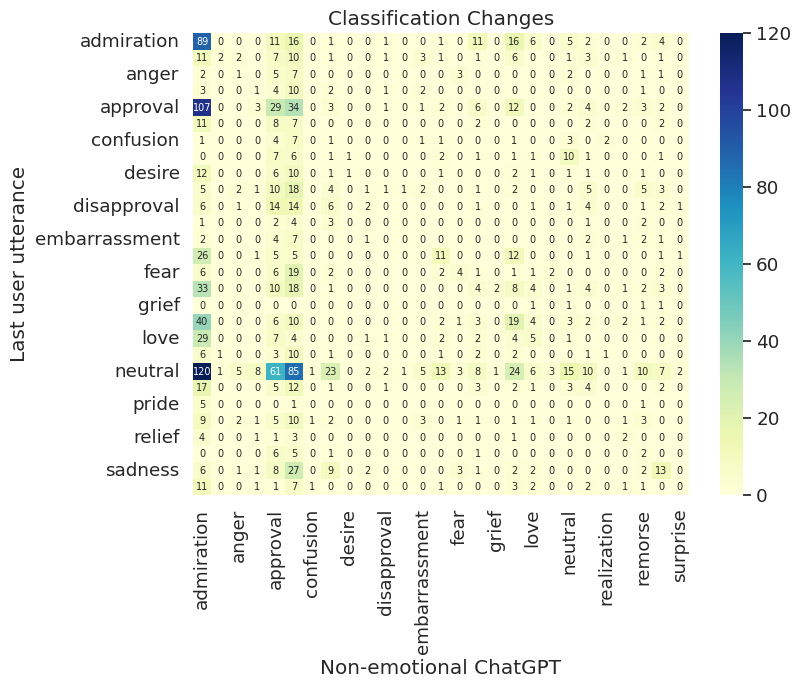

In [36]:
# Create two sample Series
s1 = chatept_output_10.utterance_minus_2_emotion
s2 = outputs_df.non_emotional_emotion

# Create a crosstab of the two Series
crosstab_non_emotional = pd.crosstab(s1, s2)

# Create a heatmap of the crosstab
plt.figure(figsize=(8,6))
sns.heatmap(crosstab_non_emotional, annot=True, cmap='YlGnBu', fmt='.0f', annot_kws={'fontsize':7})
plt.xlabel('Non-emotional ChatGPT')
plt.ylabel('Last user utterance')
plt.title('Classification Changes')
plt.show()

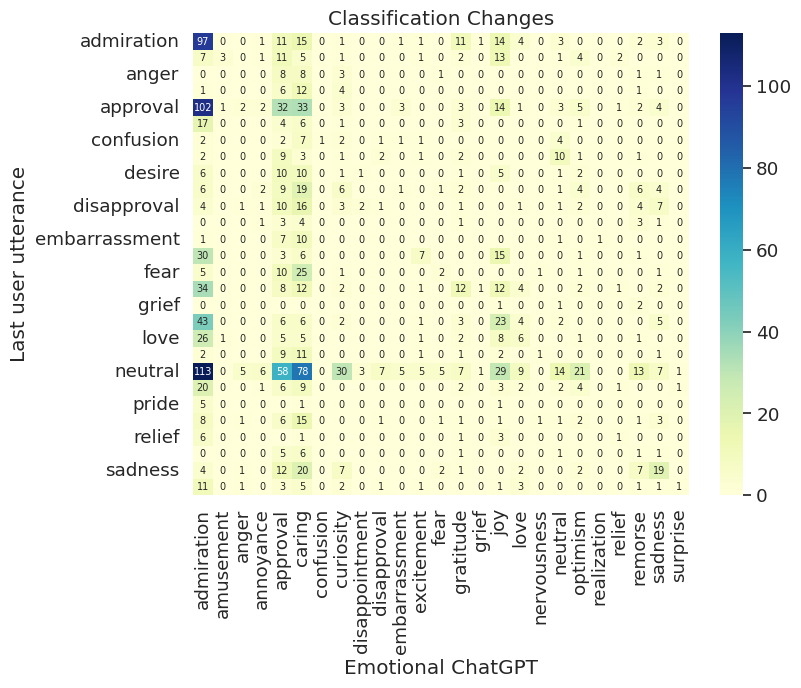

In [37]:
# Create two sample Series
s1 = chatept_output_10.utterance_minus_2_emotion
s2 = outputs_df.emotional_emotion

# Create a crosstab of the two Series
crosstab_emotional = pd.crosstab(s1, s2)

# Create a heatmap of the crosstab
plt.figure(figsize=(8,6))
sns.heatmap(crosstab_emotional, annot=True, cmap='YlGnBu', fmt='.0f', annot_kws={'fontsize':7})
plt.xlabel('Emotional ChatGPT')
plt.ylabel('Last user utterance')
plt.title('Classification Changes')
plt.show()

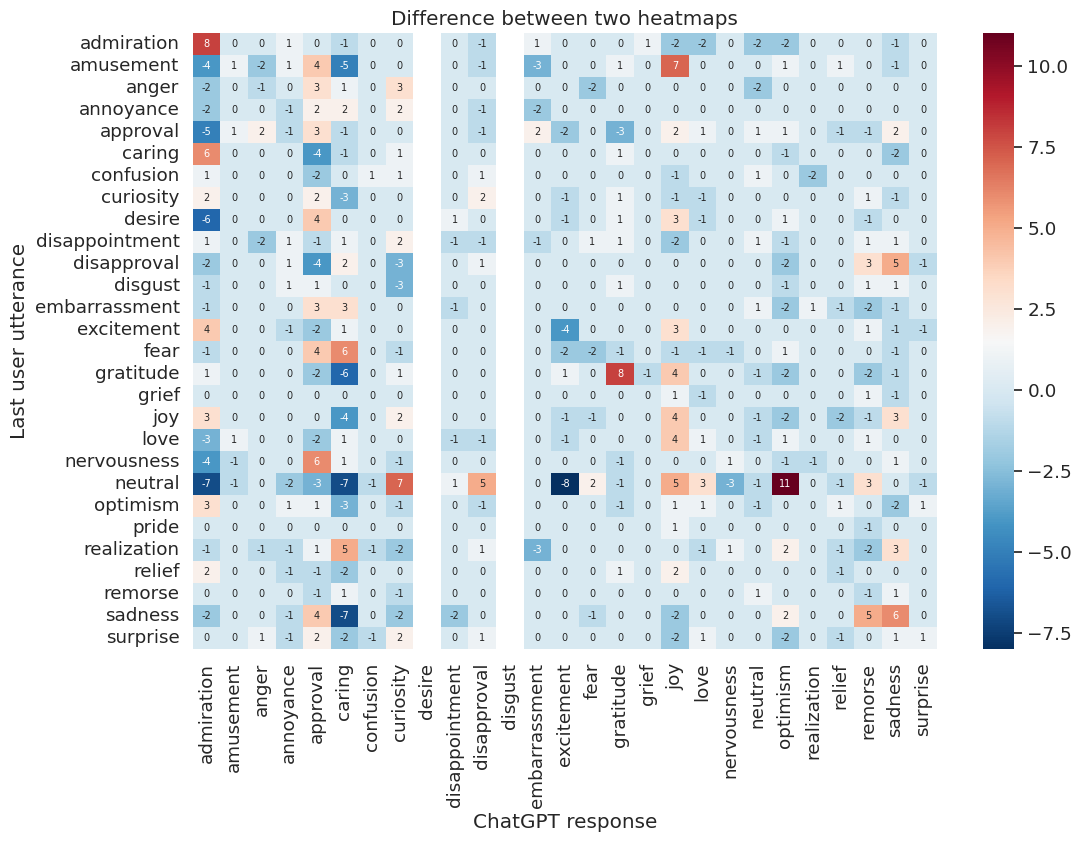

In [61]:
import numpy as np
import matplotlib.pyplot as plt

# Generate two random heatmaps
heatmap1 = np.random.rand(10, 10)
heatmap2 = np.random.rand(10, 10)

# Compute the difference between the two heatmaps
heatmap_diff = crosstab_emotional - crosstab_non_emotional

# Plot the difference heatmap
#plt.imshow(heatmap_diff, cmap='RdBu_r')
vmin = heatmap_diff.min().min()
vmax = heatmap_diff.max().max()
ticks = [vmax, (vmax + vmin) / 2, vmin]


sns.heatmap(heatmap_diff, annot=True, cmap='RdBu_r', fmt='.0f', annot_kws={'fontsize':7})
# Add a colorbar and title
#plt.colorbar()
plt.xlabel('ChatGPT response')
plt.ylabel('Last user utterance')
plt.title('Difference between two heatmaps')

# Show the plot
plt.show()

In [57]:
heatmap_diff.min().min()

-8.0